In [1]:
%load_ext autoreload
%autoreload 2

from fastai.text.all import *
import pandas as pd
import torch
from tqdm.notebook import tqdm
from utils import evaluate, evaluate_ensemble

In [2]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

# tensorflow RNG
# tf.random.set_seed(seed)

In [3]:
data_path = Path("/mnt/nas/backups/08-07-2020/desktopg01/lisa/Data/CSV")

In [4]:
model_path=Path("./models")

In [5]:
train_csv = pd.read_csv(data_path/"train_small.csv", usecols=['document_type', 'body'])
val_csv = pd.read_csv(data_path/"validation_small.csv", usecols=['document_type', 'body'])
test_csv = pd.read_csv(data_path/"test_small.csv", usecols=['document_type', 'body'])

In [6]:
train_csv["is_valid"] = False
val_csv["is_valid"] = True
data = pd.concat([train_csv, val_csv])

In [ ]:
# dls_lm = TextDataLoaders.from_df(data, seed=seed, is_lm=True, text_col="body",
#                                  valid_col="is_valid", tok_tfm=Tokenizer.from_df('body', tok=tok))

In [ ]:
dls_lm = DataBlock(
    blocks=(TextBlock.from_df('body', tok=SentencePieceTokenizer(), is_lm=True)),
    get_x=ColReader('text'), splitter=ColSplitter()).dataloaders(data)

In [ ]:
dls_lm.vocab[:15], len(dls_lm.vocab)

In [ ]:
assert len(train_csv) == len(dls_lm.train_ds) and len(val_csv) ==len(dls_lm.valid_ds)

In [ ]:
torch.save(dls_lm, "./data/dls_lm.pth")

In [5]:
dls_lm = torch.load("./data/dls_lm.pth")

In [ ]:
dls_lm.show_batch()

In [7]:
perplexity = Perplexity()
f1 = F1Score(average='macro')

In [ ]:
# config = awd_qrnn_lm_config.copy()
# config['n_hid'] = 1550 #default 1152
# config['n_layers'] = 4 #default 3

In [ ]:
# lm_fns3 = ['pt_wt_sp15_multifit', 'pt_wt_vocab_sp15_multifit']
# lm_fns3_bwd = ['pt_wt_sp15_multifit_bwd', 'pt_wt_vocab_sp15_multifit_bwd']

In [ ]:
learn_lm = language_model_learner(dls_lm, AWD_LSTM, path=Path("."), drop_mult=1., 
                                  metrics=[error_rate, accuracy, perplexity])

In [ ]:
learn_lm.save_encoder("no_fine_tune_enc")

In [ ]:
TEXT = "O Ministro"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn_lm.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [ ]:
print("\n".join(preds))

In [ ]:
learn_lm.freeze()
learn_lm.summary()

In [ ]:
learn_lm.lr_find()

In [ ]:
learn_lm.fit_one_cycle(1, 1e-1)

In [ ]:
learn_lm.recorder.plot_loss()

In [ ]:
learn_lm.save('lstm_lm_1E')

In [10]:
learn_lm.load("lstm_lm_1E")

In [11]:
learn_lm.unfreeze()

In [12]:
learn_lm.summary()

SequentialRNN (Input shape: ['64 x 72'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 72 x 1152',   1,852,416  True      
________________________________________________________________
LSTM                 ['64 x 72 x 1152',   5,317,632  True      
________________________________________________________________
LSTM                 ['64 x 72 x 400', "  1,846,400  True      
________________________________________________________________
RNNDropout           64 x 72 x 400        0          False     
________________________________________________________________
RNNDropout           64 x 72 x 1152       0          False     
________________________________________________________________
RNNDropout           64 x 72 x 1152       0          False     
________________________________________________________________
Linear               64 x 72 x 30104      12,071,704 True      
_________________________________________________________

In [ ]:
learn_lm.lr_find()

In [13]:
learn_lm.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,2.966244,2.813701,0.443039,0.556961,16.671509,44:03
1,2.675253,2.457869,0.384936,0.615065,11.679898,34:06
2,2.611775,2.390572,0.373849,0.626151,10.919739,33:42


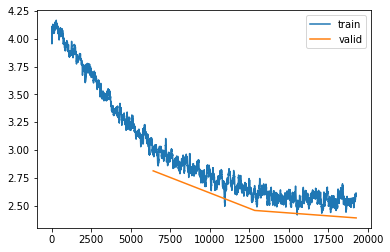

In [14]:
learn_lm.recorder.plot_loss()

In [15]:
learn_lm.save('lstm_lm_1E+3E')

Path('models/lstm_lm_1E+3E.pth')

In [16]:
learn_lm.save_encoder('lstm_lm_1E+3E_enc')

SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=8.31763736641733e-06)

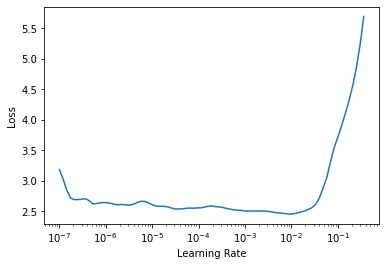

In [20]:
learn_lm.lr_find()

In [21]:
learn_lm.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,2.454777,2.338836,0.366251,0.633750,10.369164,33:51
1,2.371338,2.217347,0.348005,0.651997,9.182940,1:48:11
2,2.265793,2.180504,0.342098,0.657903,8.850764,2:10:31


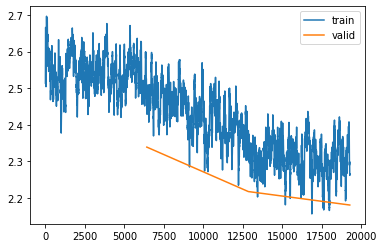

In [22]:
learn_lm.recorder.plot_loss()

In [23]:
learn_lm.save('lstm_lm_1E+3E+3E')

Path('models/lstm_lm_1E+3E+3E.pth')

In [24]:
learn_lm.save_encoder('lstm_lm_1E+3E+3E_enc')

In [25]:
TEXT = "O Ministro"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn_lm.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [26]:
print("\n".join(preds))

▁xxbos ▁o xxunk ▁ministro ▁luiz ▁fux ▁relator ▁decisão ▁que ▁possibilita ▁julgamento ▁recurso ▁presente ▁recurso ▁extraordinário ▁razão ▁pela ▁qual ▁requer ▁seja ▁admitido ▁recurso ▁extraordinário ▁interposto ▁para ▁reformar ▁acórdão ▁proferido ▁pela ▁turma ▁recursal ▁dos ▁juizados ▁especiais ▁federais ▁pernambuco ▁que ▁negou ▁provimento ▁recurso ▁inominado ▁interposto ▁pela ▁parte
▁xxbos ▁o xxunk ▁ministro ▁estado ▁previdência ▁social ▁seu ▁xxup ▁artigo _201 o ▁dispõe ▁sobre ▁regime ▁geral ▁previdência ▁social ▁os ▁seguintes ▁critérios ▁xxup ▁artigo _201 ▁previdência ▁social ▁será ▁organizada ▁sob ▁forma ▁regime ▁geral ▁caráter ▁contributivo ▁de ▁filiação ▁obrigatória ▁observados ▁critérios ▁que ▁preservem ▁equilíbrio ▁financeiro ▁atuarial


In [ ]:
dls_lm_bwd = DataBlock(
    blocks=(TextBlock.from_df('body', tok=dls_lm.tobackwards=_lm=True, backwards=True)),
    get_x=ColReader('text'), splitter=ColSplitter()).dataloaders(data)

In [7]:
assert dls_lm.vocab == dls_lm_bwd.vocab

In [8]:
del(dls_lm)

In [ ]:
torch.save(dls_lm_bwd, "./data/dls_lm_bwd.pth")

In [ ]:
dls_lm_bwd = torch.load("./data/dls_lm_bwd.pth")

In [10]:
dls_lm_bwd.show_batch()

,text,text_
0,"""} ▁código ▁seguinte ▁com ▁site ▁xxup ▁validada ▁ser ▁pode ▁certidão ▁esta ▁gerada ▁certidão ▁eletrônico ▁documento ▁inicial ▁processamento ▁coordenadoria ▁maio ▁de brasília ▁{"" ▁xxbos ""} ▁impõe ▁que ▁medida ▁pedido ▁procedência ▁discutida ▁verba ▁indenizatória ▁natureza ▁diante ▁logo ▁renda ▁imposto ▁cálculo ▁base ▁correlato ▁valor ▁dedução ▁direito ▁possuem ▁contribuintes ▁que ▁modo ▁patrimonial ▁acréscimo ▁configura ▁não ▁plano ▁déficit ▁razão ▁instituída ▁extraordinária ▁contribuição ▁título ▁social ▁seguridade ▁banrisul ▁fundação ▁pago ▁valor ▁perdida ▁foi ▁que ▁parcela ▁recomposição ▁mera ▁mas ▁matemática","▁código ▁seguinte ▁com ▁site ▁xxup ▁validada ▁ser ▁pode ▁certidão ▁esta ▁gerada ▁certidão ▁eletrônico ▁documento ▁inicial ▁processamento ▁coordenadoria ▁maio ▁de brasília ▁{"" ▁xxbos ""} ▁impõe ▁que ▁medida ▁pedido ▁procedência ▁discutida ▁verba ▁indenizatória ▁natureza ▁diante ▁logo ▁renda ▁imposto ▁cálculo ▁base ▁correlato ▁valor ▁dedução ▁direito ▁possuem ▁contribuintes ▁que ▁modo ▁patrimonial ▁acréscimo ▁configura ▁não ▁plano ▁déficit ▁razão ▁instituída ▁extraordinária ▁contribuição ▁título ▁social ▁seguridade ▁banrisul ▁fundação ▁pago ▁valor ▁perdida ▁foi ▁que ▁parcela ▁recomposição ▁mera ▁mas ▁matemática ▁reserva"
1,▁nos ▁trabalhadores ▁dos ▁habitual ▁ganho ▁constitui ▁mesma ▁que ▁natalina ▁gratificação ▁sobre ▁previdenciária ▁contribuição ▁incide ▁que ▁considerando ▁nosso ▁grifo mani ▁sor e ▁alexandr ▁convocado ▁juiz ▁relator ▁data ▁fonte ▁citação ▁teor ▁inteiro ▁região ▁federal ▁regional ▁tribunal ▁seção ▁julgador ▁orgão ▁decisão ▁data ▁uf ▁processo ▁cível ▁apelação ▁classe ▁procedente ▁parcialmente ▁autora ▁parte ▁apelação ▁pertence ▁sepúlveda ▁min ▁stf ▁condicional ▁judicial ▁título ▁sentença ▁torna _1060 ▁lei ▁xxup _11 ▁artigo ▁xxup ▁nos ▁disposto ▁aplicação ▁que ▁decidiu ▁stf ▁e ▁pois,▁trabalhadores ▁dos ▁habitual ▁ganho ▁constitui ▁mesma ▁que ▁natalina ▁gratificação ▁sobre ▁previdenciária ▁contribuição ▁incide ▁que ▁considerando ▁nosso ▁grifo mani ▁sor e ▁alexandr ▁convocado ▁juiz ▁relator ▁data ▁fonte ▁citação ▁teor ▁inteiro ▁região ▁federal ▁regional ▁tribunal ▁seção ▁julgador ▁orgão ▁decisão ▁data ▁uf ▁processo ▁cível ▁apelação ▁classe ▁procedente ▁parcialmente ▁autora ▁parte ▁apelação ▁pertence ▁sepúlveda ▁min ▁stf ▁condicional ▁judicial ▁título ▁sentença ▁torna _1060 ▁lei ▁xxup _11 ▁artigo ▁xxup ▁nos ▁disposto ▁aplicação ▁que ▁decidiu ▁stf ▁e ▁pois ▁sucumbência
2,▁disposições ▁serviço ▁tempo ▁assunto ▁não ▁mpf ▁não ▁dpu ▁processo ▁sentença ▁parte ▁reforma ▁súmula raschi ▁b cio ▁clé ▁federal ▁juiz ▁relator ▁silva ▁batista ▁adriano o ▁recd ▁previd ▁s ▁n ▁social ▁seguro ▁nacional ▁instituto ▁recte ▁aprendiz ▁aluno ▁serv ▁tempo ▁cômputo ▁averb ▁prestações ▁relativas ▁diversas ▁disposições ▁serviço ▁tempo ▁assunto ▁não ▁mpf ▁não ▁dpu ▁processo ▁sentença ▁mantém ▁súmula ecato ▁c ▁reina ilton ▁u ▁federal ▁juiz ▁relator ▁previd ▁s ▁n ▁social ▁seguro ▁nacional ▁instituto o ▁recd ▁barroso,▁serviço ▁tempo ▁assunto ▁não ▁mpf ▁não ▁dpu ▁processo ▁sentença ▁parte ▁reforma ▁súmula raschi ▁b cio ▁clé ▁federal ▁juiz ▁relator ▁silva ▁batista ▁adriano o ▁recd ▁previd ▁s ▁n ▁social ▁seguro ▁nacional ▁instituto ▁recte ▁aprendiz ▁aluno ▁serv ▁tempo ▁cômputo ▁averb ▁prestações ▁relativas ▁diversas ▁disposições ▁serviço ▁tempo ▁assunto ▁não ▁mpf ▁não ▁dpu ▁processo ▁sentença ▁mantém ▁súmula ecato ▁c ▁reina ilton ▁u ▁federal ▁juiz ▁relator ▁previd ▁s ▁n ▁social ▁seguro ▁nacional ▁instituto o ▁recd ▁barroso a
3,"▁decisão ▁que ▁admitir ▁implicará ▁jurisdicional ▁exame ▁trazido ▁jurídico ▁argumento ▁sólido ▁como ▁acolher ▁instância ▁última ▁de ▁recorrida ▁decisão ▁conseqüência ▁processo ▁neste ▁exame ▁trazido ▁dico ▁jurí ▁argumento ▁acolhido ▁examinado ▁tenha ▁que ▁judiciária ▁seção ▁seja ▁que ▁qualquer ▁federais ▁especiais ▁juizados ▁dos ▁recursal ▁turma ▁mento ▁pronuncia ▁não ▁conhecer ▁autora ▁parte ▁dado ▁onde ▁até ▁associados ▁advogados ▁silva ▁ivo o anild ▁{"" ▁xxbos ""} ▁nacional ▁fazenda ▁procurador ▁s

In [11]:
learn_lm = language_model_learner(dls_lm_bwd, AWD_LSTM, path=Path("."), drop_mult=1., 
                                  metrics=[error_rate, accuracy, perplexity])

In [12]:
learn_lm.freeze()
learn_lm.summary()

SequentialRNN (Input shape: ['64 x 72'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 72 x 1152',   1,852,416  False     
________________________________________________________________
LSTM                 ['64 x 72 x 1152',   5,317,632  False     
________________________________________________________________
LSTM                 ['64 x 72 x 400', "  1,846,400  False     
________________________________________________________________
RNNDropout           64 x 72 x 400        0          False     
________________________________________________________________
RNNDropout           64 x 72 x 1152       0          False     
________________________________________________________________
RNNDropout           64 x 72 x 1152       0          False     
________________________________________________________________
Linear               64 x 72 x 30104      12,071,704 True      
_________________________________________________________

SuggestedLRs(lr_min=0.13182567358016967, lr_steep=0.0691830962896347)

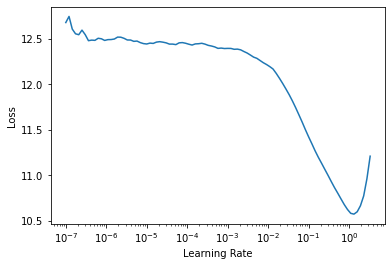

In [13]:
learn_lm.lr_find()

In [14]:
learn_lm.fit_one_cycle(1, 1e-1)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,4.280356,3.839558,0.587987,0.412012,46.504898,34:48


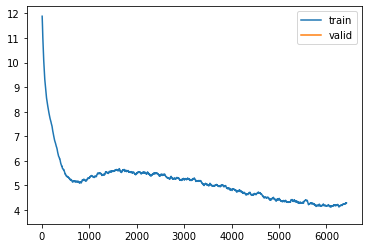

In [15]:
learn_lm.recorder.plot_loss()

In [16]:
learn_lm.save('lstm_lm_1E_bwd')

Path('models/lstm_lm_1E_bwd.pth')

In [ ]:
learn_lm.load("lstm_lm_1E_bwd")

In [17]:
learn_lm.unfreeze()

In [18]:
learn_lm.summary()

SequentialRNN (Input shape: ['64 x 72'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 72 x 1152',   1,852,416  True      
________________________________________________________________
LSTM                 ['64 x 72 x 1152',   5,317,632  True      
________________________________________________________________
LSTM                 ['64 x 72 x 400', "  1,846,400  True      
________________________________________________________________
RNNDropout           64 x 72 x 400        0          False     
________________________________________________________________
RNNDropout           64 x 72 x 1152       0          False     
________________________________________________________________
RNNDropout           64 x 72 x 1152       0          False     
________________________________________________________________
Linear               64 x 72 x 30104      12,071,704 True      
_________________________________________________________

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=2.2908675418875646e-06)

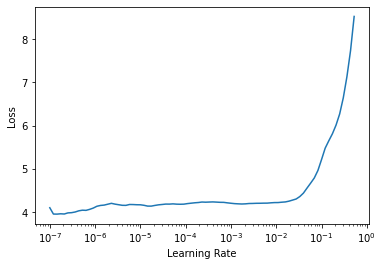

In [19]:
learn_lm.lr_find()

In [21]:
learn_lm.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,3.064942,2.808604,0.436870,0.563130,16.586742,36:38
1,2.674922,2.457955,0.380191,0.619809,11.680904,38:53
2,2.495064,2.391142,0.369993,0.630008,10.925968,40:58


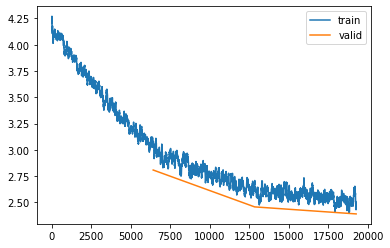

In [22]:
learn_lm.recorder.plot_loss()

In [23]:
learn_lm.save('lstm_lm_1E+3E_bwd')

Path('models/lstm_lm_1E+3E_bwd.pth')

In [24]:
learn_lm.save_encoder('lstm_lm_1E+3E_enc_bwd')

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=0.0063095735386013985)

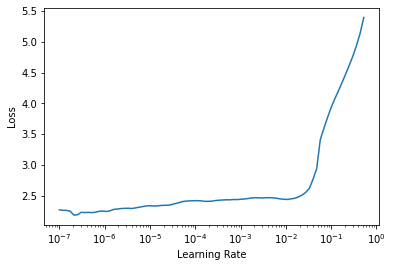

In [25]:
learn_lm.lr_find()

In [26]:
learn_lm.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,2.528972,2.336559,0.362176,0.637825,10.345572,35:43
1,2.352913,2.218098,0.344520,0.655481,9.189833,42:00
2,2.255635,2.180773,0.338580,0.661420,8.853151,35:39


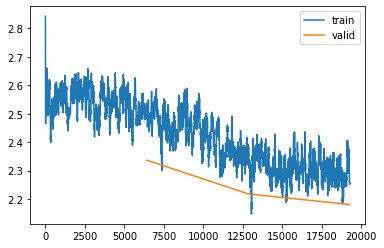

In [27]:
learn_lm.recorder.plot_loss()

In [28]:
learn_lm.save('lstm_lm_1E+3E+3E_bwd')

Path('models/lstm_lm_1E+3E+3E_bwd.pth')

In [29]:
learn_lm.save_encoder('lstm_lm_1E+3E+3E_enc_bwd')

In [9]:
dls = DataBlock(
    blocks=(TextBlock.from_df('body', tok=dls_lm_bwd.tok),  CategoryBlock),
    get_x=ColReader('text'), get_y=ColReader('document_type'), splitter=ColSplitter()).dataloaders(data)

/mnt/home/peluz/victor-visual-text/fastai2/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [10]:
assert dls.vocab[0] == dls_lm_bwd.vocab

In [ ]:
del(dls_lm_bwd)

In [12]:
torch.save(dls, "./data/dls.pth")

In [8]:
dls = torch.load("./data/dls.pth")

In [11]:
n_samples = len(dls.train_ds); n_samples

149217

In [12]:
class_counts = torch.bincount(torch.stack(list(dls.train_ds.tls[1][:])))

In [13]:
class_weights = n_samples / (dls.c * class_counts); class_weights

TensorCategory([44.9720,  9.7681, 71.8772,  0.1854,  2.6154, 11.6813])

In [14]:
class_weights = torch.FloatTensor(class_weights).cuda(); class_weights

tensor([44.9720,  9.7681, 71.8772,  0.1854,  2.6154, 11.6813], device='cuda:0')

In [33]:
learn = text_classifier_learner(dls, AWD_LSTM, path=Path("."), drop_mult=1., 
                                loss_func=CrossEntropyLossFlat(weight=class_weights),
                                metrics=[accuracy, f1])

In [34]:
learn.load_encoder("lstm_lm_1E+3E+3E_enc")

In [35]:
learn.freeze()
learn.summary()

SequentialRNN (Input shape: ['64 x 4867'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 43 x 1152',   1,852,416  False     
________________________________________________________________
LSTM                 ['64 x 43 x 1152',   5,317,632  False     
________________________________________________________________
LSTM                 ['64 x 43 x 400', "  1,846,400  False     
________________________________________________________________
RNNDropout           64 x 43 x 400        0          False     
________________________________________________________________
RNNDropout           64 x 43 x 1152       0          False     
________________________________________________________________
RNNDropout           64 x 43 x 1152       0          False     
________________________________________________________________
BatchNorm1d          64 x 1200            2,400      True      
_______________________________________________________

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=2.2908675418875646e-06)

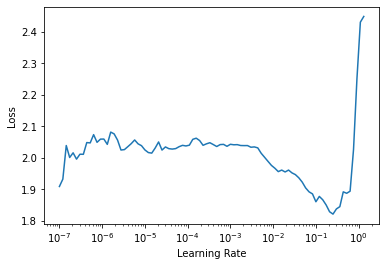

In [37]:
learn.lr_find()

In [38]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.961801,0.864121,0.610271,0.298024,07:35


In [39]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.695018,0.644269,0.688901,0.368934,12:21


In [40]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.498383,0.598076,0.711680,0.404785,18:18


In [41]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.435686,0.570500,0.758579,0.449526,19:18
1,0.484861,0.559896,0.765198,0.440880,12:41


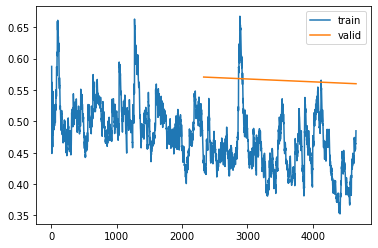

In [42]:
learn.recorder.plot_loss()

In [43]:
learn.save('fwd_clf')

Path('models/fwd_clf.pth')

In [ ]:
learn.load("fwd_clf")

In [5]:
dls = torch.load("./data/dls.pth")

In [8]:
learn = text_classifier_learner(dls, AWD_LSTM, path=Path("."), drop_mult=1., 
                                metrics=[accuracy, f1])

In [9]:
learn.load_encoder("lstm_lm_1E+3E+3E_enc")

In [10]:
learn.freeze()
learn.summary()

SequentialRNN (Input shape: ['64 x 4867'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 43 x 1152',   1,852,416  False     
________________________________________________________________
LSTM                 ['64 x 43 x 1152',   5,317,632  False     
________________________________________________________________
LSTM                 ['64 x 43 x 400', "  1,846,400  False     
________________________________________________________________
RNNDropout           64 x 43 x 400        0          False     
________________________________________________________________
RNNDropout           64 x 43 x 1152       0          False     
________________________________________________________________
RNNDropout           64 x 43 x 1152       0          False     
________________________________________________________________
BatchNorm1d          64 x 1200            2,400      True      
_______________________________________________________

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.2089296132326126)

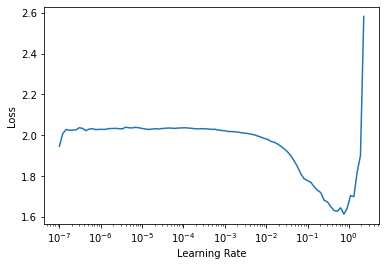

In [11]:
learn.lr_find()

In [12]:
learn.fit_one_cycle(1, 5e-2)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.387957,0.300711,0.907648,0.416662,06:13


In [13]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.240733,0.405872,0.926521,0.604740,07:15


In [14]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.195939,0.217716,0.932274,0.654567,10:06


In [15]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.187477,0.212550,0.932971,0.668708,12:33
1,0.197332,0.232083,0.934860,0.680430,12:32


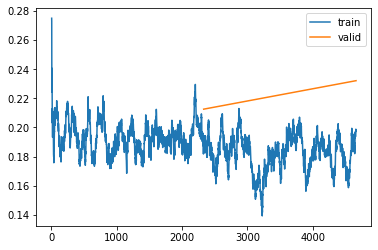

In [16]:
learn.recorder.plot_loss()

In [17]:
learn.save('fwd_clf')

Path('models/fwd_clf.pth')

In [ ]:
learn.load("fwd_clf")

In [ ]:
dls_bwd = DataBlock(
    blocks=(TextBlock.from_df('body', tok=dls.tok, backwards=True),  CategoryBlock),
    get_x=ColReader('text'), get_y=ColReader('document_type'), splitter=ColSplitter()).dataloaders(data)

In [ ]:
assert dls.vocab[0] == dls_bwd.vocab[0]

In [18]:
del(dls)

In [18]:
torch.save(dls_bwd, "./data/dls_bwd.pth")

In [19]:
dls_bwd = torch.load("./data/dls_bwd.pth")

In [20]:
learn = text_classifier_learner(dls_bwd, AWD_LSTM, path=Path("."), drop_mult=1., 
#                                 loss_func=CrossEntropyLossFlat(weight=class_weights),
                                metrics=[accuracy, f1])

In [21]:
learn.load_encoder("lstm_lm_1E+3E+3E_enc_bwd")

In [22]:
learn.freeze()
learn.summary()

SequentialRNN (Input shape: ['64 x 4867'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 43 x 1152',   1,852,416  False     
________________________________________________________________
LSTM                 ['64 x 43 x 1152',   5,317,632  False     
________________________________________________________________
LSTM                 ['64 x 43 x 400', "  1,846,400  False     
________________________________________________________________
RNNDropout           64 x 43 x 400        0          False     
________________________________________________________________
RNNDropout           64 x 43 x 1152       0          False     
________________________________________________________________
RNNDropout           64 x 43 x 1152       0          False     
________________________________________________________________
BatchNorm1d          64 x 1200            2,400      True      
_______________________________________________________

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.12022644281387329)

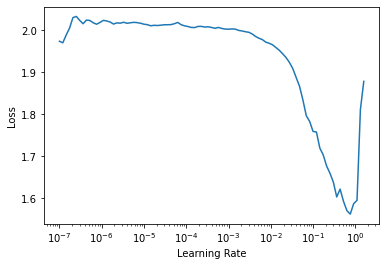

In [23]:
learn.lr_find()

In [24]:
learn.fit_one_cycle(1, 5e-2)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.420884,0.318758,0.904164,0.404002,06:30


In [25]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.236000,0.225309,0.928632,0.621345,07:13


In [26]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.194959,0.211865,0.931905,0.679259,10:02


In [27]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.175763,0.204344,0.934934,0.683419,12:25
1,0.182911,0.208312,0.935863,0.692171,12:28


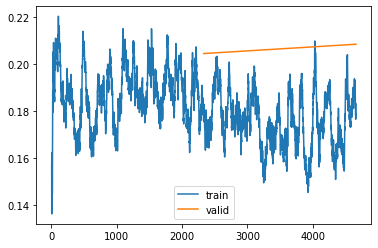

In [28]:
learn.recorder.plot_loss()

In [30]:
learn.save('bwd_clf')

Path('models/bwd_clf.pth')

In [ ]:
learn.load("bwd_clf")

In [29]:
learn = text_classifier_learner(dls_bwd, AWD_LSTM, path=Path("."), drop_mult=1., 
                                loss_func=CrossEntropyLossFlat(weight=class_weights),
                                metrics=[accuracy, f1])

In [30]:
learn.load_encoder("lstm_lm_1E+3E+3E_enc_bwd")

In [31]:
learn.freeze()
learn.summary()

SequentialRNN (Input shape: ['64 x 4867'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 43 x 1152',   1,852,416  False     
________________________________________________________________
LSTM                 ['64 x 43 x 1152',   5,317,632  False     
________________________________________________________________
LSTM                 ['64 x 43 x 400', "  1,846,400  False     
________________________________________________________________
RNNDropout           64 x 43 x 400        0          False     
________________________________________________________________
RNNDropout           64 x 43 x 1152       0          False     
________________________________________________________________
RNNDropout           64 x 43 x 1152       0          False     
________________________________________________________________
BatchNorm1d          64 x 1200            2,400      True      
_______________________________________________________

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=7.585775847473997e-07)

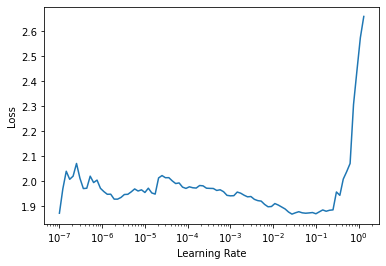

In [32]:
learn.lr_find()

In [33]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.076835,0.873939,0.610820,0.300344,06:10


In [34]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.633418,0.688326,0.649570,0.347064,07:11


In [35]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.557222,0.628877,0.698253,0.392610,10:05


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.458864,0.582287,0.751000,0.434046,12:26


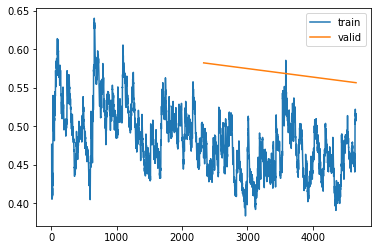

In [38]:
learn.recorder.plot_loss()

### Evaluate

In [8]:
dls = torch.load("./data/dls.pth")

In [9]:
test_csv["is_valid"]=True

In [10]:
test_items = tokenize_df(test_csv, "body", tok=dls.tok)

/mnt/home/peluz/victor-visual-text/fastai2/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [11]:
test_dl = dls.test_dl(test_items[0], with_labels=True)

In [12]:
assert test_dl.vocab  == dls.vocab

In [13]:
learn_fwd = text_classifier_learner(dls, AWD_LSTM, path=Path("."), drop_mult=1., 
                                    metrics=[accuracy, f1])

In [14]:
learn_fwd.load("fwd_clf")

In [19]:
evaluate(learn_fwd, test_dl, 0)

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.6342    0.8828    0.7381       273
agravo_em_recurso_extraordinario     0.5486    0.3156    0.4007      1841
     despacho_de_admissibilidade     0.5076    0.5051    0.5063       198
                          outros     0.9543    0.9797    0.9668     85408
                   peticao_do_RE     0.7991    0.6244    0.7010      6331
                        sentenca     0.8176    0.6990    0.7537      1475

                        accuracy                         0.9377     95526
                       macro avg     0.7102    0.6677    0.6778     95526
                    weighted avg     0.9322    0.9377    0.9334     95526



In [20]:
dls_bwd = torch.load("./data/dls_bwd.pth")

In [21]:
test_dl_bwd = dls_bwd.test_dl(test_items[0], with_labels=True)

In [22]:
assert test_dl_bwd.vocab  == dls_bwd.vocab; del(dls_bwd)

In [23]:
test_dl_bwd.show_batch()

,text,category
0,"""} ▁l sina ▁ ana ▁n ▁for ▁a ▁3 ▁xxrep em ▁a da ▁m ▁abe bm ▁ai mas pn ▁g p ▁gre ry men ▁fe ▁for tr ya ▁al ▁d lando lf ▁ret o las m ▁c am ▁pei reme ▁ o ▁r ▁tia ▁que ▁a ra s ▁profe ll ça ▁ ▁uma ine ▁re ▁fim ▁den a ▁uf ▁e ▁por wn ▁ tani ▁u da o ▁i ▁mau ▁r m ▁rp ▁w s ▁maio m ▁cn ▁mala uti o ▁s parte ▁a a yn ▁cor ▁ca vin ▁p gb ▁r ▁cia ▁por ▁a o ▁ai m o ▁ix ma p vi ▁c m gn ▁ i ▁mm m ▁el m am ▁ ▁i ▁3 ▁xxrep ▁se qf ▁s a ace a o ▁ed ar ha o ▁r tl ▁a ▁ama ▁nos nb ri py m ▁in ▁l nd d ▁carpe m m ▁o am ndo ▁a ▁el s á",outros
1,"xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad ""} ▁mesa ▁secretária ▁silva ▁camargo a",outros
2,"xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad ""} ▁costa ▁carlos ▁marisa ▁a ▁a",outros
3,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,outros
4,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpa

In [24]:
learn_bwd = text_classifier_learner(dls, AWD_LSTM, path=Path("."), drop_mult=1., 
                                    metrics=[accuracy, f1])

In [25]:
learn_bwd.load("bwd_clf")

In [26]:
evaluate(learn_bwd, test_dl_bwd)

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.7264    0.8755    0.7940       273
agravo_em_recurso_extraordinario     0.5519    0.3205    0.4055      1841
     despacho_de_admissibilidade     0.5309    0.5202    0.5255       198
                          outros     0.9593    0.9768    0.9680     85408
                   peticao_do_RE     0.7650    0.6917    0.7265      6331
                        sentenca     0.8034    0.6759    0.7342      1475

                        accuracy                         0.9394     95526
                       macro avg     0.7228    0.6768    0.6923     95526
                    weighted avg     0.9346    0.9394    0.9361     95526



In [29]:
evaluate_ensemble(learn_fwd, learn_bwd, test_dl, test_dl_bwd)

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.7301    0.8718    0.7947       273
agravo_em_recurso_extraordinario     0.5832    0.3140    0.4082      1841
     despacho_de_admissibilidade     0.5495    0.5051    0.5263       198
                          outros     0.9564    0.9804    0.9683     85408
                   peticao_do_RE     0.7941    0.6557    0.7183      6331
                        sentenca     0.8127    0.6854    0.7437      1475

                        accuracy                         0.9402     95526
                       macro avg     0.7377    0.6687    0.6932     95526
                    weighted avg     0.9347    0.9402    0.9360     95526

